# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Goals

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a round-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natural selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


# Import libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
from itertools import combinations 
%matplotlib inline

# Classes

### 1. Player
A __Player__ object represents the actual entity that plays the Prisoner's Dilemma. Each __Player__ is characterized by the attributes:
* __movesHistory__ $\rightarrow$ array that contains in position i the strategy adopted on turn i (strategy can be either [1, 0] - cooperate or [0, 1] - defect). Initialized as empty
* __enemymovesHistory__ $\rightarrow$ array that contains in position i the strategy adopted by the opponent on turn i (strategy can be either [1, 0] - cooperate or [0, 1] - defect). Initialized as empty 
* __gain__ $\rightarrow$ array that contains in position i the gain obtained by the player on turn i (the values follow the value of the entries of the matrix M - see next sections). Initialized as empty
* __k__ $\rightarrow$ scalar parameter (0 $\leq$ k $\leq$ 1) that indicates *how nice* and *how bad* is a player


and owns a constructor:
* __\_\_init\_\_(self, strategy, k = np.nan)__ $\rightarrow$ initializes a Player. Sets the player strategy (that can be changed during the game) and the value of k

plus a bunch of methods:
* __makeMove(self)__ $\rightarrow$ returns a different move depending on the strategy of the player
  * __cooperate(self)__ $\rightarrow$ returns the *cooperate move* [1, 0]
  * __defect(self)__ $\rightarrow$ returns the *defect move* [0, 1]
  * __mainlyniceMove(self)__ $\rightarrow$ let k be s.t. 0 <= k < 0.5. The player will cooperate with probability (1 - k) and at the same time it will defect with probability k
  * __mainlybadMove(self)__ $\rightarrow$ let k be s.t. 0.5 <= k <= 1. The player will cooperate with probability (1 - k) and at the same time it will defect with probability k
  * __titfortatMove(self)__ $\rightarrow$ the player copies the strategy adopted by its opponent, but from the first move that is always *cooperate*
  * __spitefulMove(self)__ $\rightarrow$ cooperates until the opponent defects and thereafter always defects
  * __proberMove(self)__ $\rightarrow$ plays the sequence d, c, c then always defects if its opponent has cooperated in the moves 2 and 3. Plays as tit_for_tat in other cases
  * __hard_majoMove(self)__ $\rightarrow$ defects on the first move and defects if the number of defections of the opponent is greater than or equal to the number of times she has cooperated. Else she cooperates 
  * __tf2tMove(self)__ $\rightarrow$ cooperates the two first moves, then defects only if the opponent has defected during the two previous moves
  * __pavlovMove(self)__ $\rightarrow$ cooperates on the first move and defects only if both the players did not agree on the previous move
  


In [7]:
class Player:
  # @attribute movesHistory
  #   Array that contains in position i the strategy adopted
  #   on turn i (strategy can be either [1, 0] - cooperate 
  #   or [0, 1] - defect). Initialized as empty.
  movesHistory = np.empty((0, 2), int)

  # @attribute enemymovesHistory
  #   Array that contains in position i the strategy adopted
  #   by the opponent on turn i (strategy can be either [1, 0]
  #   - cooperate or [0, 1] - defect). Initialized as empty.
  enemymovesHistory = np.empty((0, 2), int)

  # @attribute gain
  #   Array that contains in position i the gain obtained by 
  #   the player on turn i (the values follow the value of 
  #   the entries of the matrix M - see next sections). 
  #   Initialized as empty.
  gain = np.array([])

  # @constructor
  #   Initializes a Player. Sets the player's strategy (that can
  #   be changed during the game) and the value of k. 
  def __init__(self, strategy, k = np.nan):
    self.strategy = strategy
    if(k >= 0 and k <= 1):
      self.k = k
    else:
      self.k = np.nan
  
  # @method makeMove
  #   Returns a different move depending on
  #   the strategy of the player
  def makeMove(self):
    if(self.strategy == 'nice'):
      return self.cooperate()
    elif(self.strategy == 'bad'):
      return self.defect()
    elif(self.strategy == 'mainly nice'):
      return self.mainlyniceMove()
    elif(self.strategy == 'mainly bad'):
      return self.mainlynibadMove()
    elif(self.strategy == 'tit-for-tat'):
      return self.titfortatMove()
    elif(self.strategy == 'spiteful'):
      return self.spitefulMove()
    elif(self.strategy == 'prober'):
      return self.proberMove()
    elif(self.strategy == 'hard majo'):
      return self.hard_majoMove()
    elif(self.strategy == 'tf2t'):
      return self.tf2tMove()
    elif(self.strategy == 'pavlov'):
      return self.pavlovMove()
    else:
      return np.array([0,0])

  # @method cooperate
  #   Returns the *cooperate move* [1, 0]
  def cooperate(self):
    return np.array([1, 0])

  # @method defect
  #   Returns the *defect move* [0, 1]
  def defect(self):
    return np.array([0, 1])
      
  # @method mainlyniceMove
  #   Let k be s.t. 0 <= k < 0.5. The player will
  #   cooperate with probability (1 - k) and at the
  #   same time it will defect with probability k
  def mainlyniceMove(self):
    choice = np.random.choice([1, 0], p = [1 - self.k, self.k])
    if(choice == 1):         
      return self.cooperate()
    else:
      return self.defect() 

  # @method mainlybadMove
  #   Let k be s.t. 0.5 <= k <= 1. The player will
  #   cooperate with probability (1 - k) and at the
  #   same time it will defect with probability k
  def mainlynibadMove(self):
    choice = np.random.choice([1, 0], p = [1 - self.k, self.k])
    if(choice == 1):         
      return self.cooperate()
    else:
      return self.defect() 
  
  # @method titfortatMove
  #   The player copies the strategy adopted by its
  #   opponent, but from the first move that is
  #   always cooperate
  def titfortatMove(self):
    if(len(self.enemymovesHistory) == 0):
      return self.cooperate()
    else:
      return self.enemymovesHistory[-1]

  # @method spitefulMove
  #   Cooperates until the opponent defects and
  #   thereafter always defects
  def spitefulMove(self):
    if(self.defect() in self.enemymovesHistory):
      return self.defect()
    else:
      return self.cooperate()

  # @method proberMove
  #   Plays the sequence d, c, c then always
  #   defects if its opponent has cooperated in
  #   the moves 2 and 3. Plays as tit_for_tat in
  #   other cases
  def proberMove(self):
    if(len(self.movesHistory) == 0):
      return self.defect()
    elif(len(self.movesHistory) <= 2):
      return self.cooperate()
    else:
      if(np.all(self.enemymovesHistory[1] == self.cooperate()) and \
          np.all(self.enemymovesHistory[2] == self.cooperate())):
        return self.defect()
      else:
        return self.titfortatMove()
    return

  # @method hard_majoMove
  #   Defects on the first move
  #   then defects if the number of defections of the opponent
  #   is equal to or more than the number of cooperations of the opponent
  #   otherwise cooperates
  def hard_majoMove(self):
    if len(self.movesHistory) == 0:
      return self.defect()
    else:
      nDefect = 0
      nCooperate = 0

      for i in self.enemymovesHistory:
        if i[0] == 1:
          nCooperate += 1
        else:
          nDefect += 1

      if nDefect >= nCooperate:
        return self.defect()
      else:
        return self.cooperate()

  # @method tf2tMove
  #   cooperates the two first moves, then defects only if the opponent 
  #   has defected during the two previous moves 
  def tf2tMove(self):
    if len(self.movesHistory) == 0 or len(self.movesHistory) == 1:
      return self.cooperate()
    elif self.enemymovesHistory[-1][0] == 0 and self.enemymovesHistory[-2][0] == 0:
      return self.defect()
    else:
      return self.cooperate()
  
  # @method pavlov
  #   cooperates on the first move and defects only if both the players 
  #   did not agree on the previous move
  def pavlovMove(self):
    if len(self.movesHistory) == 0 or len(self.enemymovesHistory) == 0:
      return self.cooperate()
    elif (self.enemymovesHistory[-1][0] == self.movesHistory[-1][0]):
      return self.cooperate()
    return self.defect()

# Auxiliary Functions

### random_players(n)

In [8]:
# @function random_players
#   Creates and returns a list of n players.
#   The strategy for each player is picked up
#   from the list of implemented strategies.
def random_players(n):
  strategies = ['bad', 'nice', 'mainly nice', 'mainly bad', 'tit-for-tat', \
    'spiteful', 'prober', 'hard majo', 'tf2t', 'pavlov']
  players = []

  for i in range(0, n):
    choice = random.choice(strategies)
    if(choice == 'mainly nice'):
      k = random.random()
      while(k >= 0.5):
        k = random.random()
      p = Player(choice, k)
    elif(choice == 'mainly bad'):
      k = random.random()
      while(k < 0.5):
        k= random.random()
      p = Player(choice, k)
    else:
      p = Player(choice)
    players.append(p)

  return players

### generate_players(strategies, nps)

In [9]:
# @function generate_players
#    Generate nps[i] players according to the
#    strategy strategies[i]
def generate_players(strategies, nps):
  if(len(strategies) != len(nps)):
    print('Invalid arguments')
    return
    
  players = []
  for i in range(0, len(nps)):
    for j in range(0, nps[i]):
      if(strategies[i] == 'mainly nice'):
        k = random.random()
        while(k >= 0.5):
          k = random.random()
        players.append(Player(strategies[i], k))
      elif(strategies[i] == 'mainly bad'):
        k = random.random()
        while(k < 0.5):
          k = random.random()
        players.append(Player(strategies[i], k))
      else:
        players.append(Player(strategies[i]))
        
  return players

### max_gainP(players)

In [10]:
# @function max_gainP
#   Finds the player with the higher gain
#   in its gain history.
def max_gainP(players):
  max_gainP = 0
  max_gain = 0
  for i in range(0, len(players)):
    tmp = np.sum(players[i].gain)
    if(tmp > max_gain):
      max_gain = tmp
      max_gainP = players[i]

  return max_gainP

### min_gainP(players)

In [11]:
# @function min_gainP
#   Finds the player with the lower gain
#   in its gain history.
def min_gainP(players):
  min_gainP = 0
  min_gain = 10000000
  for i in range(0, len(players)):
    tmp = np.sum(players[i].gain)
    if(tmp < min_gain):
      min_gain = tmp
      min_gainP = players[i]

  return min_gainP

### reset(players)

In [12]:
# @function reset
#   Resets players by emptying their
#   attributes.
def reset(players):
  for i in range(0, len(players)):
    players[i].movesHistory = np.empty((0, 2), int) 
    players[i].enemymovesHistory = np.empty((0, 2), int) 
    players[i].gain = np.array([])

  return

### battle(p1, p2, M)

In [13]:
# @function battle
#   Implements a single round between two
#   players, according to their strategies.
def battle(p1, p2, M): 

  m1 = p1.makeMove() 
  m2 = p2.makeMove()

  # Update p1 histories
  p1.movesHistory = np.append(p1.movesHistory, np.array([m1]), axis = 0)
  p1.enemymovesHistory = np.append(p1.enemymovesHistory, np.array([m2]), axis = 0)

  # Update p2 histories
  p2.movesHistory = np.append(p2.movesHistory, np.array([m2]), axis = 0)
  p2.enemymovesHistory = np.append(p2.enemymovesHistory, np.array([m1]), axis = 0)
  
  # Compute the gain for the two players
  r1 = np.dot(np.dot(m1.T, M), m2)
  r2 = np.dot(np.dot(m2.T, M), m1)
  p1.gain = np.append(p1.gain, r1)
  p2.gain = np.append(p2.gain, r2)

  return

### Battle types

#### war(p1, p2, n, M, ass1) $\rightarrow$ *assignment 1*

In [14]:
# @function war
#   Performs n battles between p1 and p2.
#   Before every war, the attributes of 
#   each player are resetted for the assignment 1. At the end,
#   results are shown for the assignment 1 (see method 
#   show_results).
def war(p1, p2, n, M, ass1 = True):
  if(ass1):
    reset([p1, p2])

  for i in range(0,n):
    battle(p1, p2, M)

  if(ass1):
    show_result([p1, p2], n)

  return

#### round_robin_tournament(p, n, M) ($\rightarrow$ *assignment 2*)

In [15]:
# @function round_robin_tournament
#   Uses the function round_robin_scheduler
#   to organize the order in which the players
#   fixture, and then performs the actual
#   battles.
def round_robin_tournament(p, n, M):
  days = round_robin_scheduler(p)

  for i in days:
    for k in range(0, len(i)):
       #print("{} vs {}".format(i[k][0].strategy,i[k][1].strategy))
        war(i[k][0], i[k][1], n, M, ass1 = False)

### Schedule Types

#### round_robin_scheduler(players)

In [16]:
# @function round_robin_scheduler
#   Returns the schedule of the games according
#   to the round robin scheme ("girone all'italiana").
def round_robin_scheduler(players): 
    if len(players) % 2 != 0:   
        print("The number of players must be even")
        return
        
    n = int(len(players))
    matches = []
    calendar = []
    for j in range(1, n):
        for i in range(int(n/2)):
            matches.append((players[i], players[n - 1 - i]))
        players.insert(1, players.pop())
        calendar.insert(int(len(calendar)/2), matches)
        matches = []
    return calendar

### Plot Results

#### show_result(p, n)

In [17]:
# @function show_result
#   Plots the results of a fixture among
#   players. On the left plot, the history
#   their moves: a cooperation moves the
#   position on the right, while a defection
#   moves the position up. On the right plot,
#   the gain obtained round by round. 
def show_result(p, n):
  fig, ax = plt.subplots(1, 2, figsize = (20, 7))

  ax[0].plot(np.arange(0, n * len(p) / 2), np.arange(0, n * len(p) / 2), \
             '--', color = 'black', alpha = 0.3)
  ax[0].set_title("Moves History")
  ax[0].set_xlabel("Defect")
  ax[0].set_ylabel("Cooperate")

  ax[1].set_title("Gain History")
  ax[1].set_xlabel("Move Number")
  ax[1].set_ylabel("Gain")

  for x in p:
    ax[0].plot(np.cumsum(x.movesHistory, axis = 0)[:, 1], \
               np.cumsum(x.movesHistory, axis = 0)[:, 0], label = x.strategy)
    ax[1].plot(np.cumsum(x.gain), label = x.strategy)
  
  ax[0].legend()
  ax[1].legend()
  plt.show()

  return

#### show_populations(players)

In [18]:
# @function show_populations
#   Shows the number of players for each strategy during the
#   development of the game.
def show_populations(rounds):
  x = np.arange(0, len(rounds))
  bad = np.zeros(len(rounds))
  nice = np.zeros(len(rounds))
  m_nice = np.zeros(len(rounds))
  m_bad = np.zeros(len(rounds))
  tft = np.zeros(len(rounds))
  spiteful = np.zeros(len(rounds))
  prober = np.zeros(len(rounds))
  hardMajo = np.zeros(len(rounds))
  tf2t = np.zeros(len(rounds))
  pavlov = np.zeros(len(rounds))
  for i in x:
    bad[i] = rounds[i]['bad']
    nice[i] = rounds[i]['nice']
    m_nice[i] = rounds[i]['mainly nice']
    m_bad[i] = rounds[i]['mainly bad']
    tft[i] = rounds[i]['tit-for-tat']
    spiteful[i] = rounds[i]['spiteful']
    prober[i] = rounds[i]['prober']
    hardMajo[i] = rounds[i]['hard majo']
    tf2t[i] = rounds[i]['tf2t']
    pavlov[i] = rounds[i]['pavlov']

  plt.figure(figsize = (10, 7))
  plt.plot(x + 1, bad, label = 'bad')
  plt.plot(x + 1, nice, label = 'nice')
  plt.plot(x + 1, m_nice, label = 'mainly nice')
  plt.plot(x + 1, m_bad, label = 'mainly bad')
  plt.plot(x + 1, tft, label = 'tit-for-tat')
  plt.plot(x + 1, spiteful, label = 'spiteful')
  plt.plot(x + 1, prober, label = 'prober')
  plt.plot(x + 1, hardMajo, label = 'hard majo')
  plt.plot(x + 1, tf2t, label = 'tf2t')
  plt.plot(x + 1, pavlov, label = 'pavlov')
  plt.legend(loc = (1.04, 0))
  plt.xlabel('Round')
  plt.ylabel('Population')
  plt.show()

  print('Final populations:')
  print('...bad', bad[-1])
  print('...nice', nice[-1])
  print('...mainly bad', m_bad[-1])
  print('... mainly nice', m_nice[-1])
  print('...tit-for-tat', tft[-1])
  print('...spiteful', spiteful[-1])
  print('...prober', prober[-1])
  print('...hard majo', hardMajo[-1])
  print('...tf2t', tf2t[-1])
  print('...pavlov', pavlov[-1])

  return

# First Assignment

Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations.

A _war_ is a series of n _battles_. A _battle_ involves two players. 

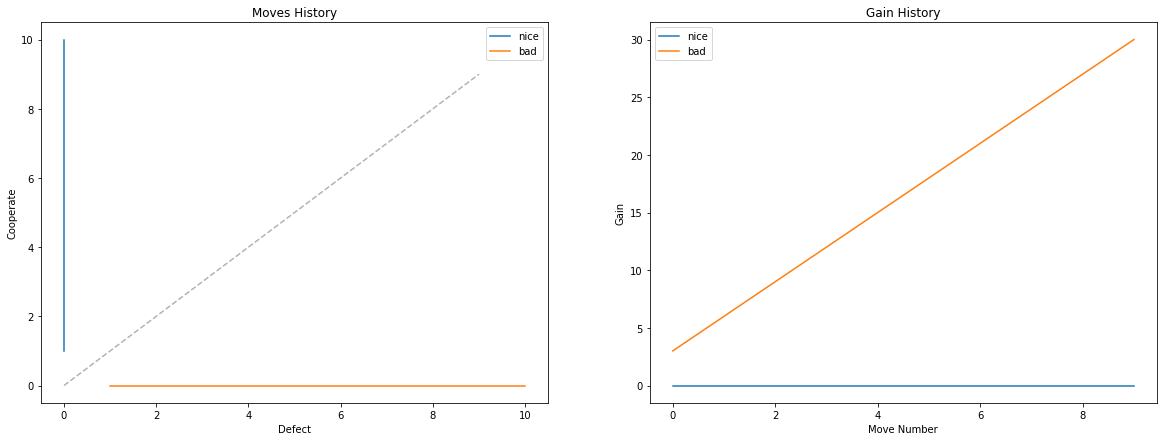

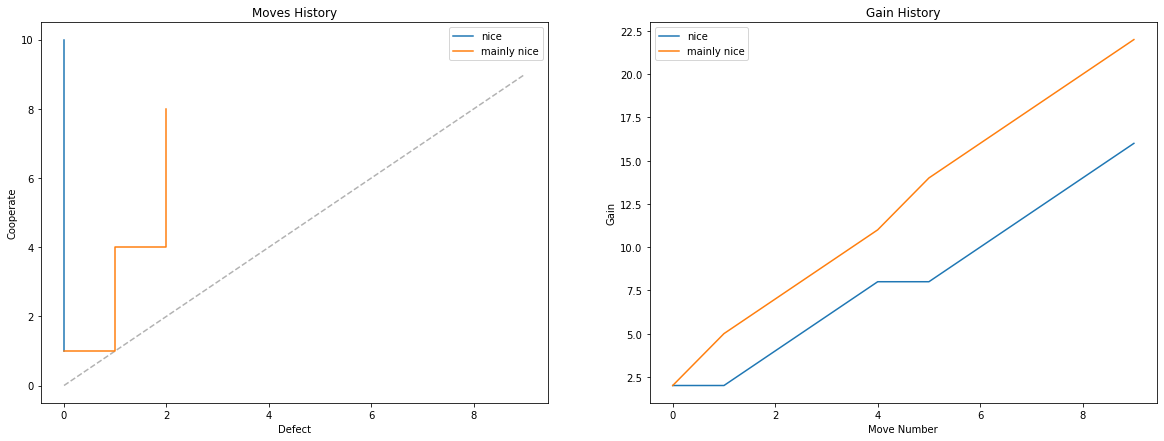

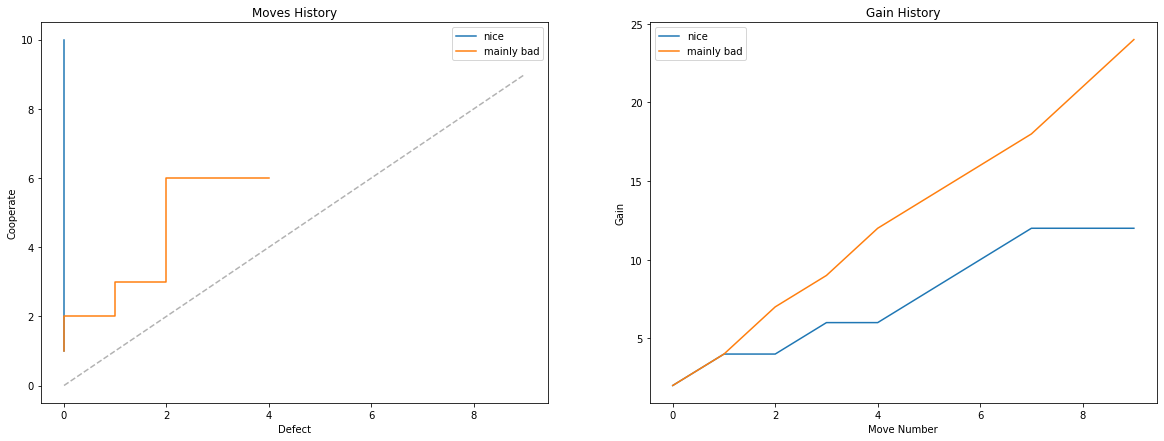

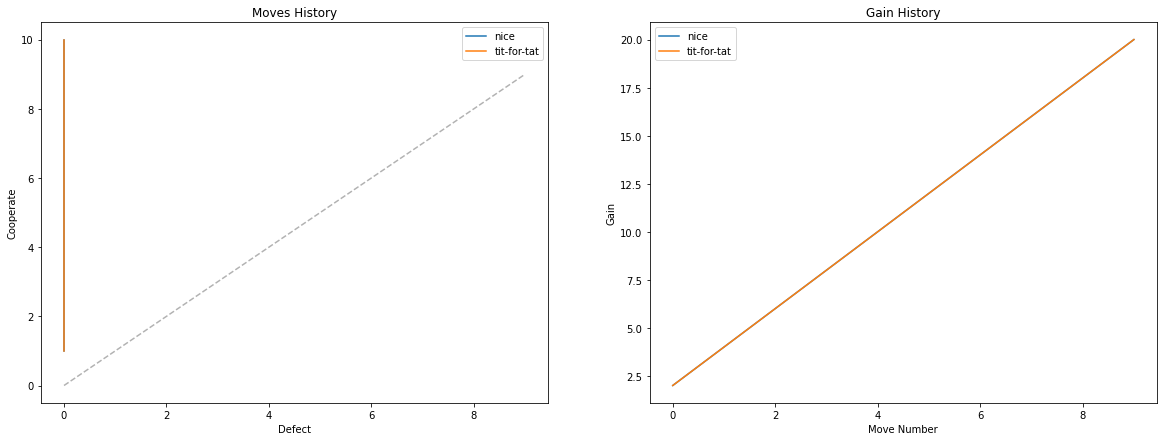

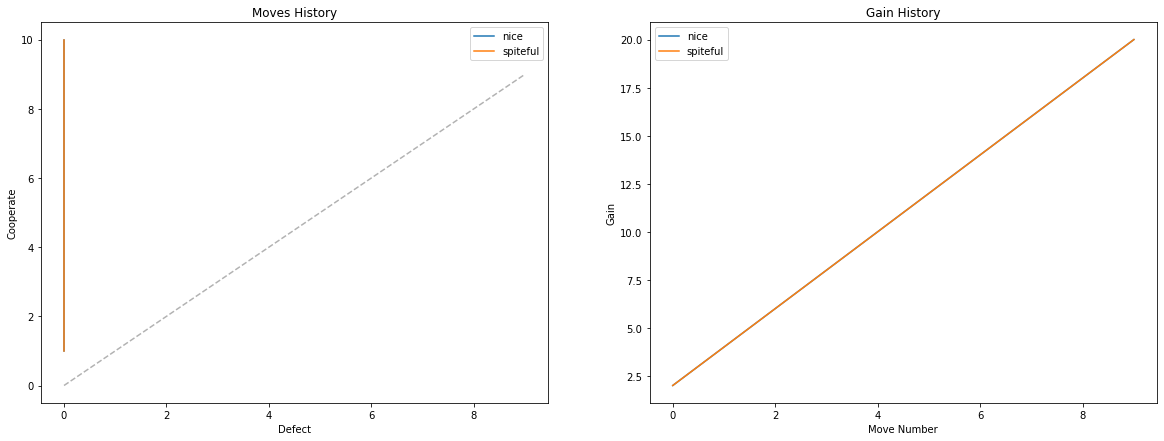

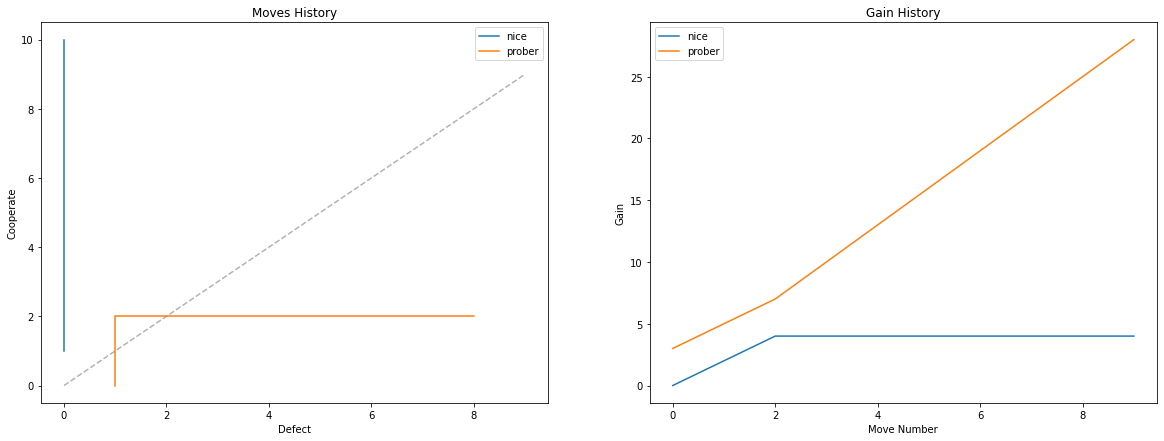

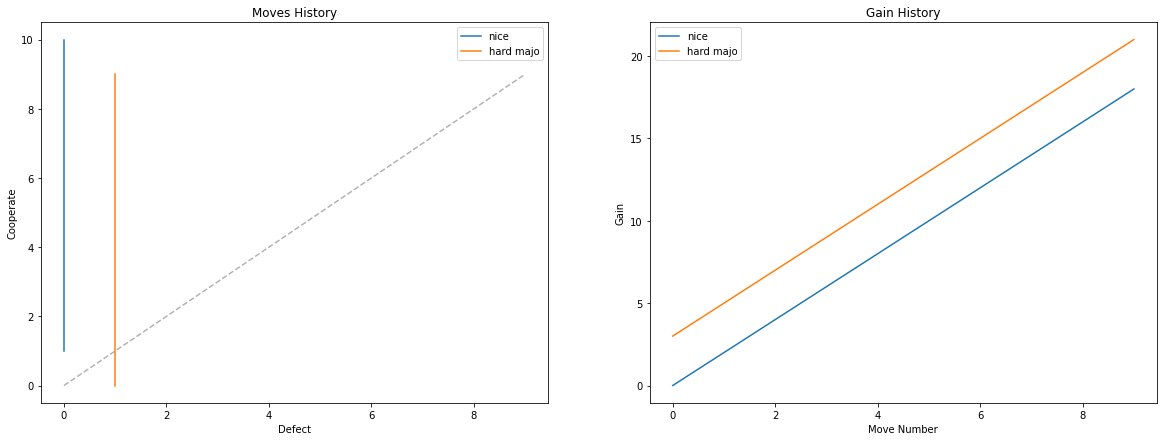

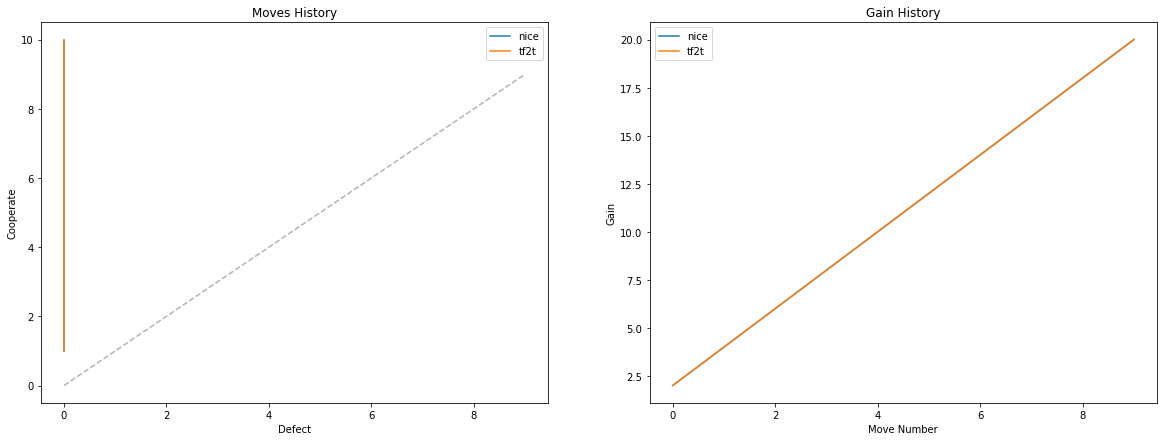

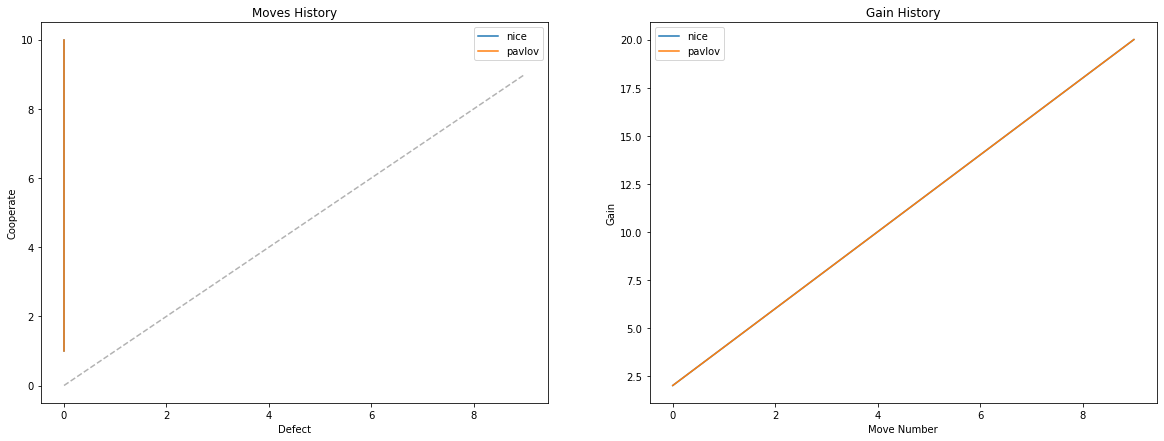

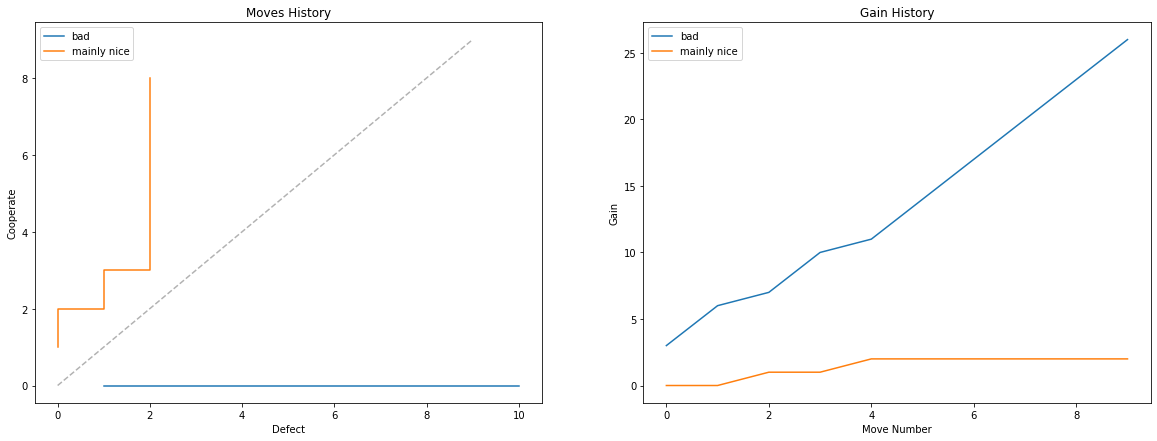

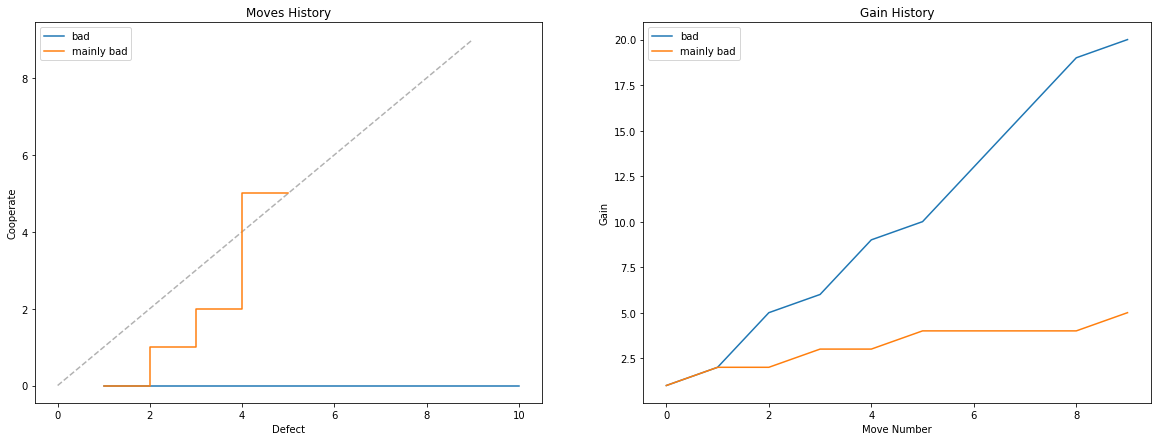

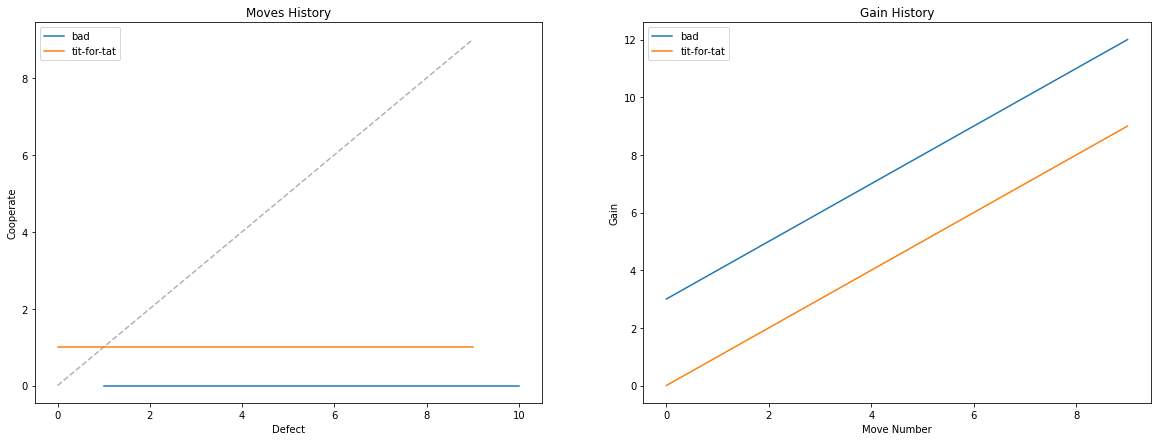

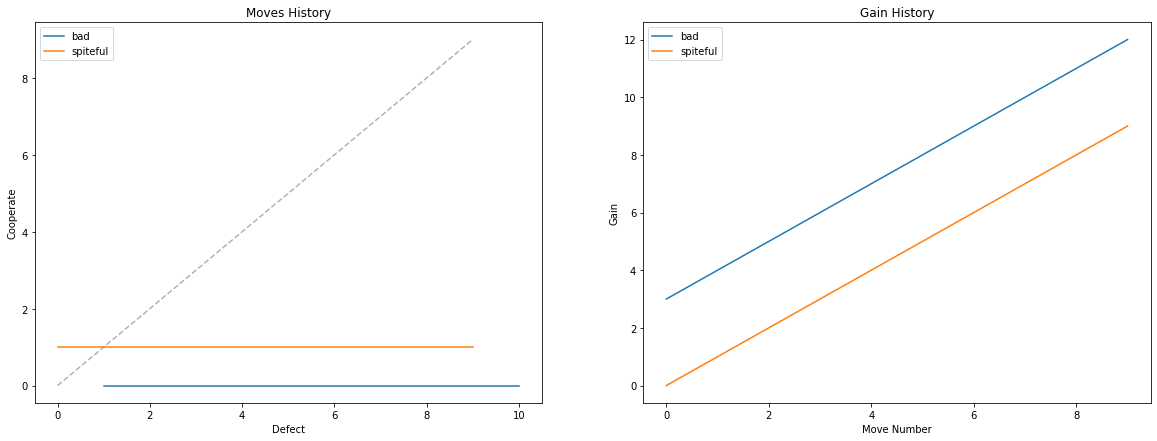

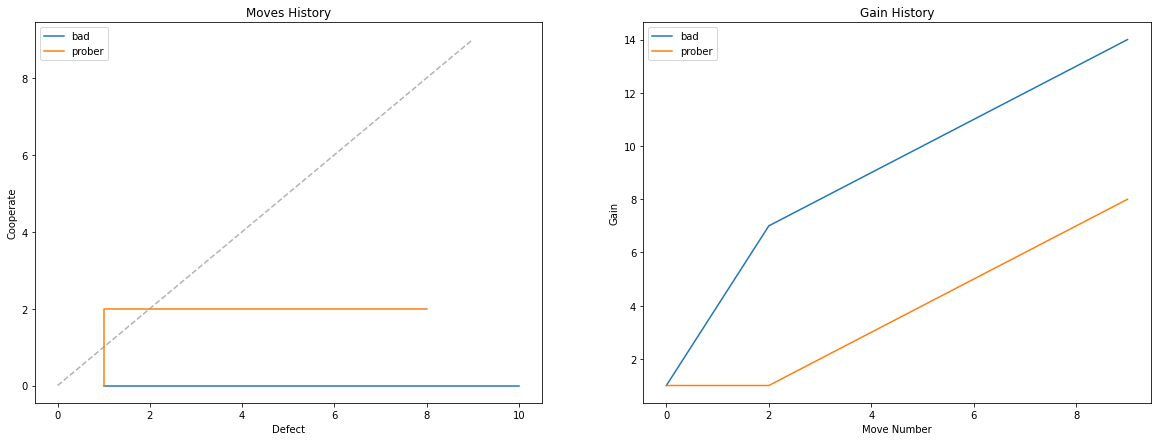

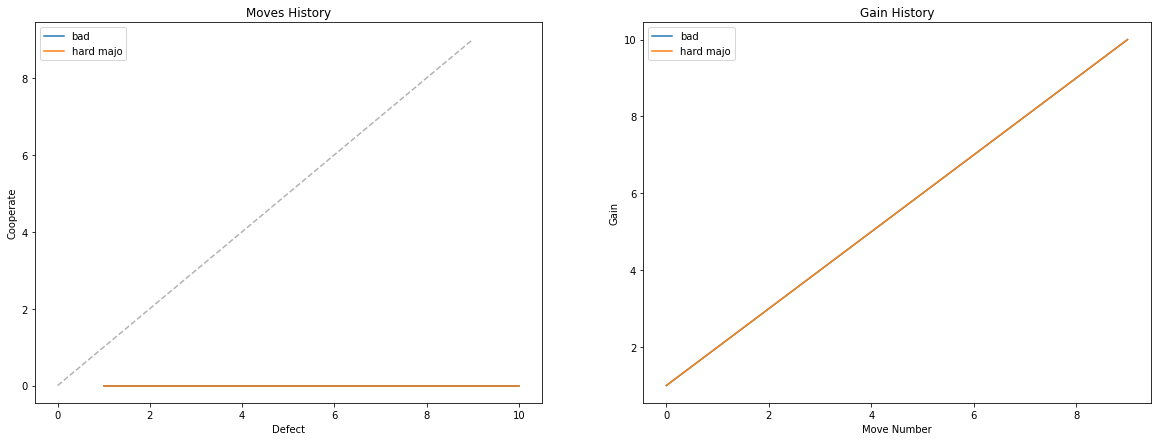

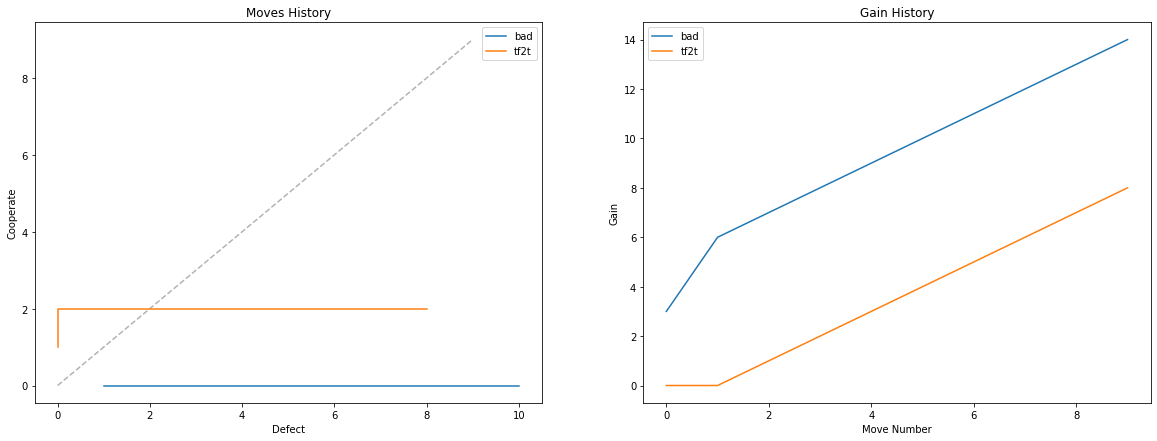

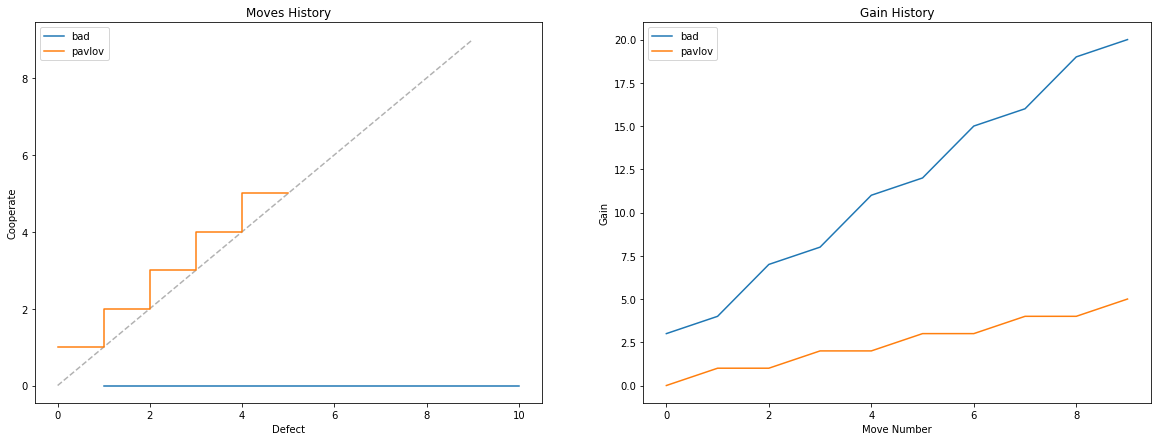

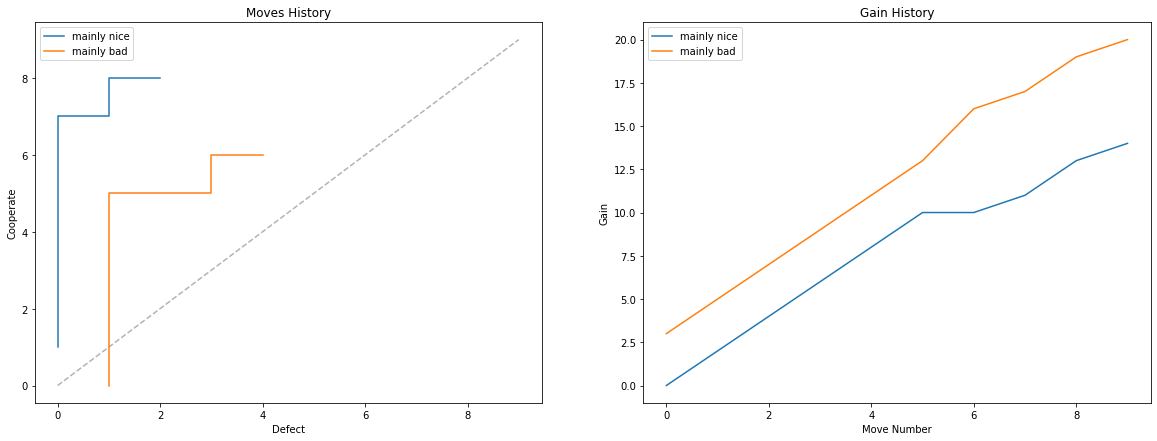

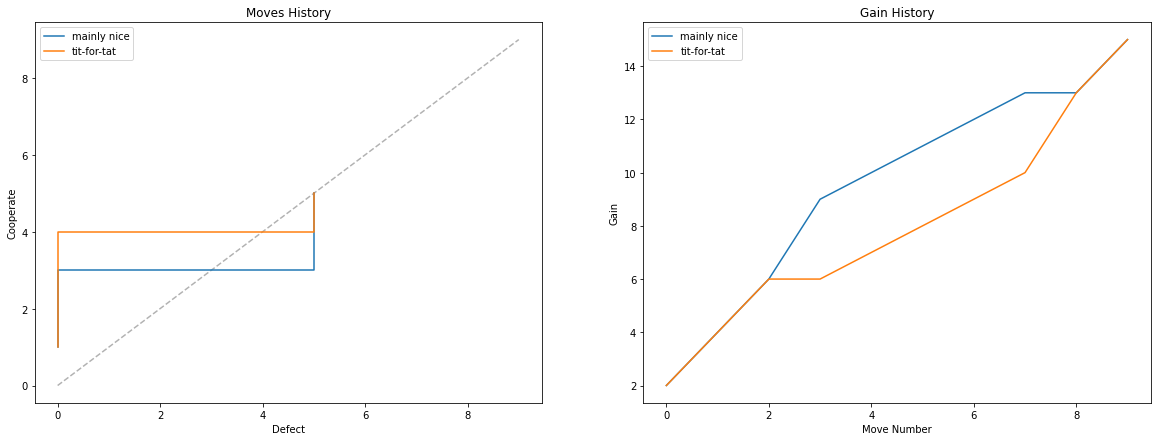

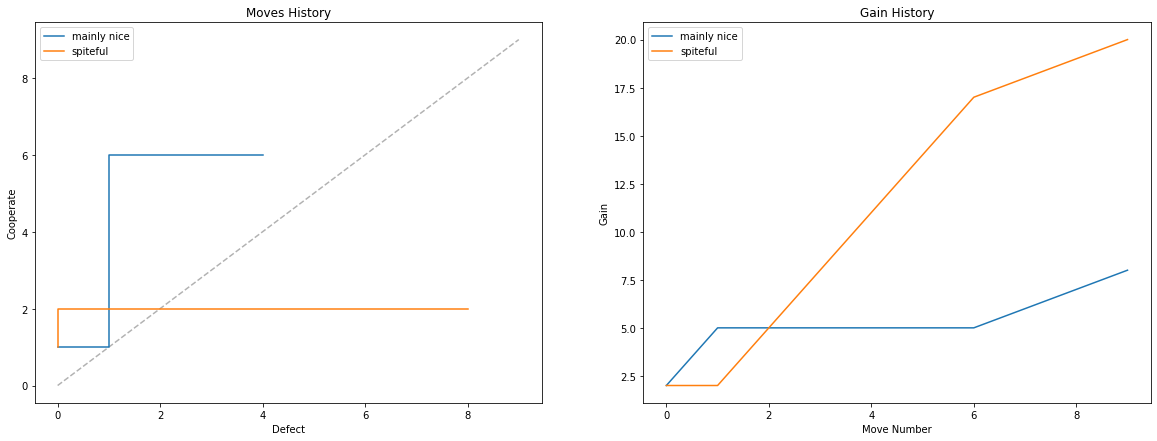

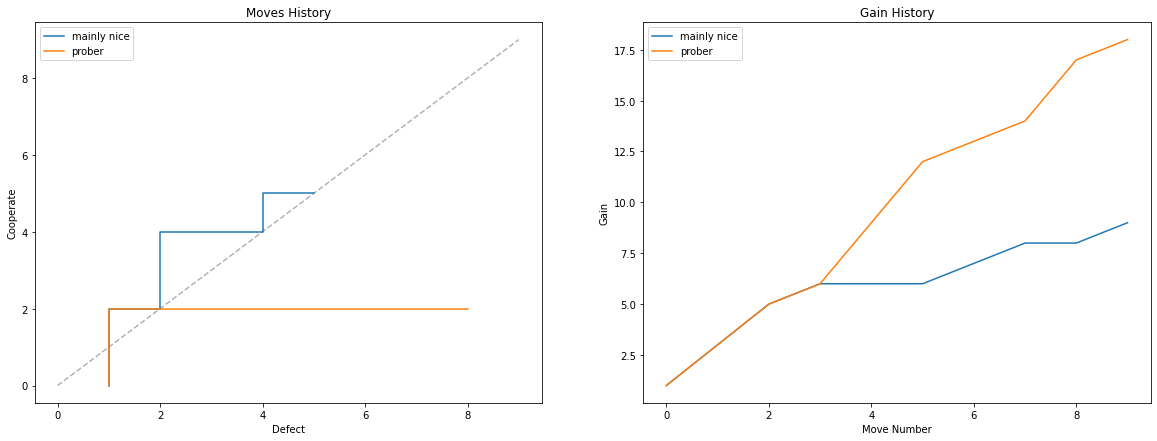

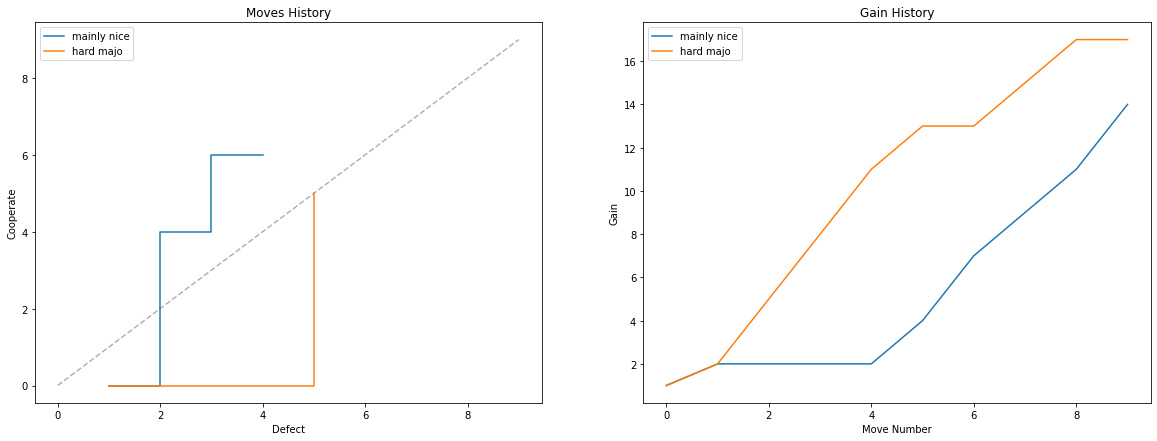

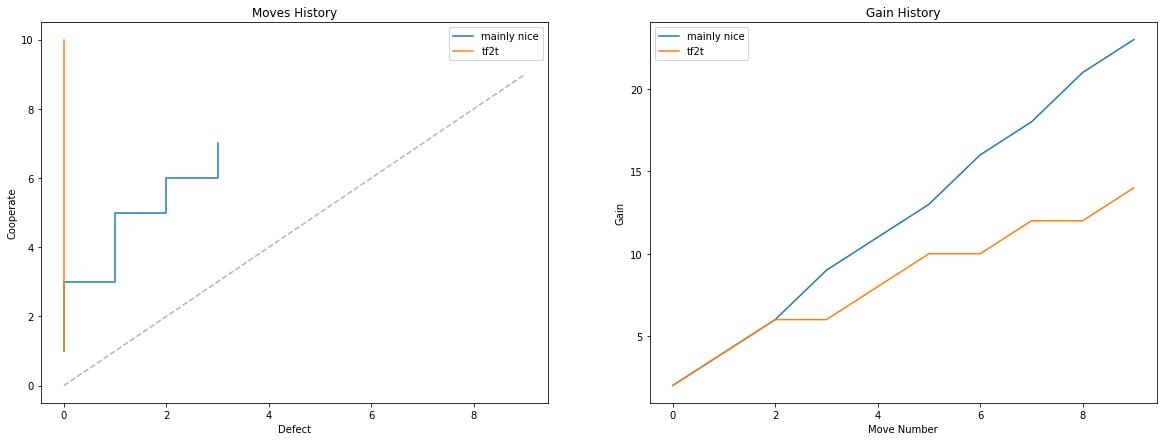

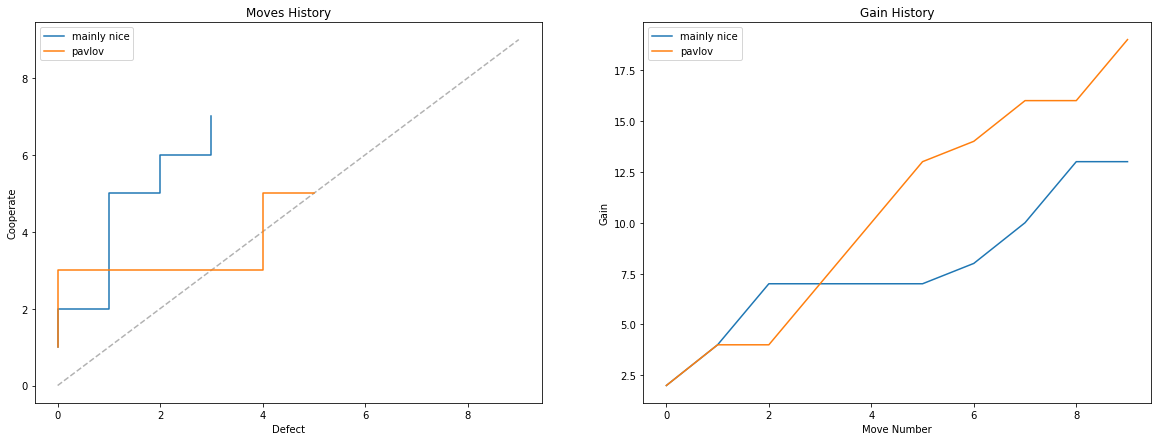

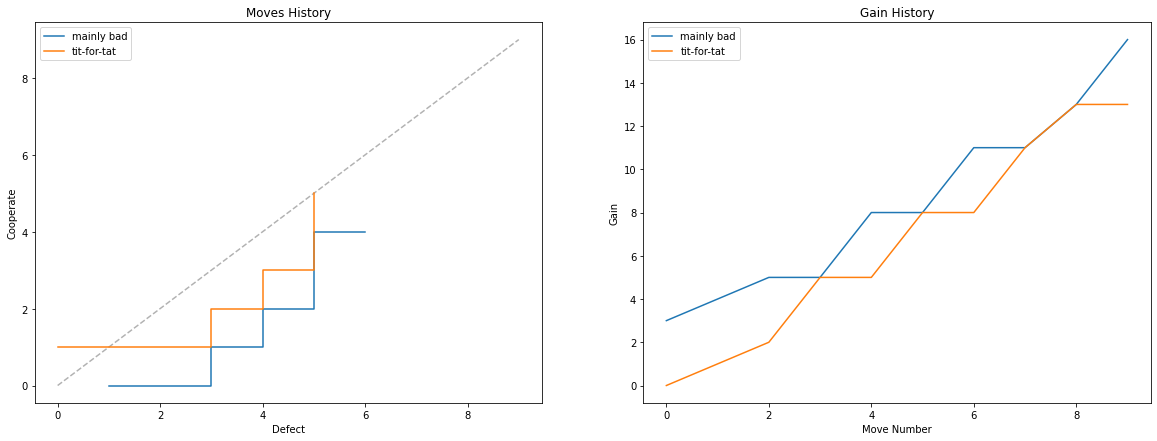

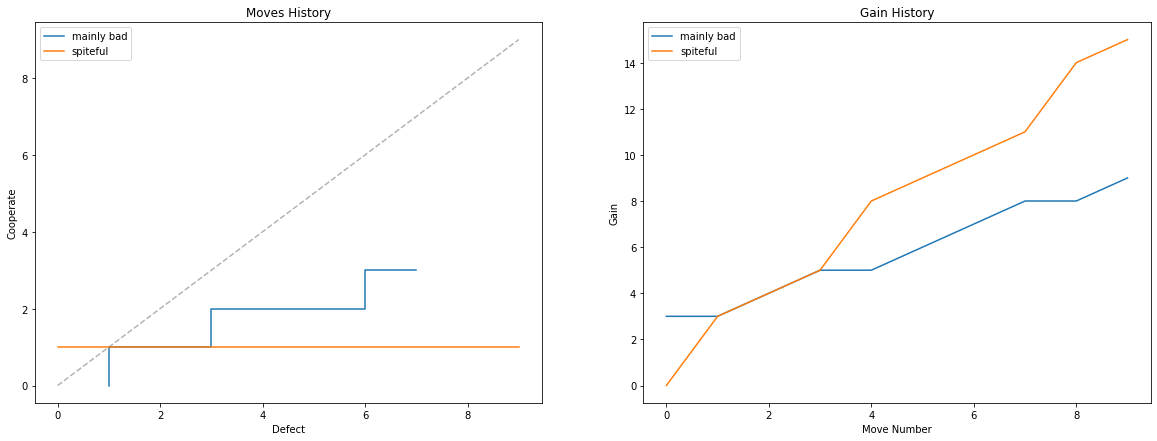

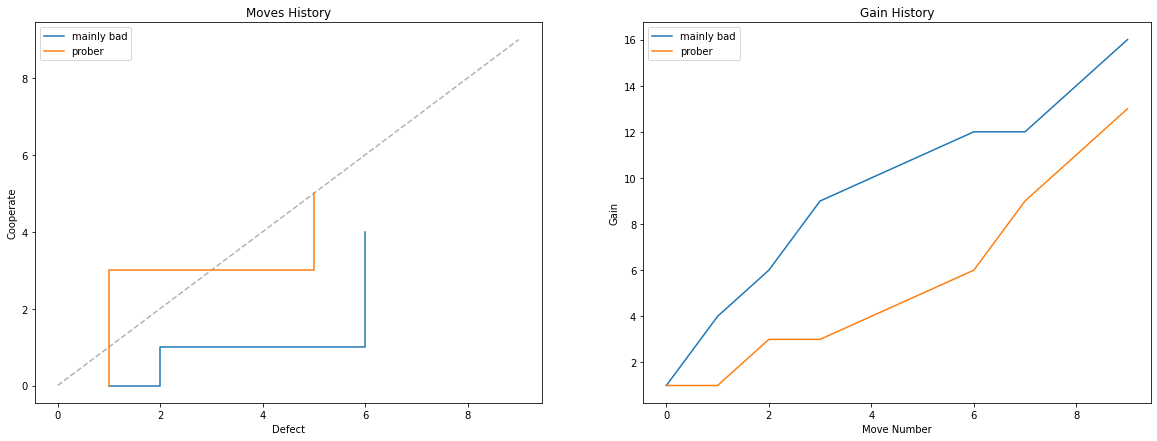

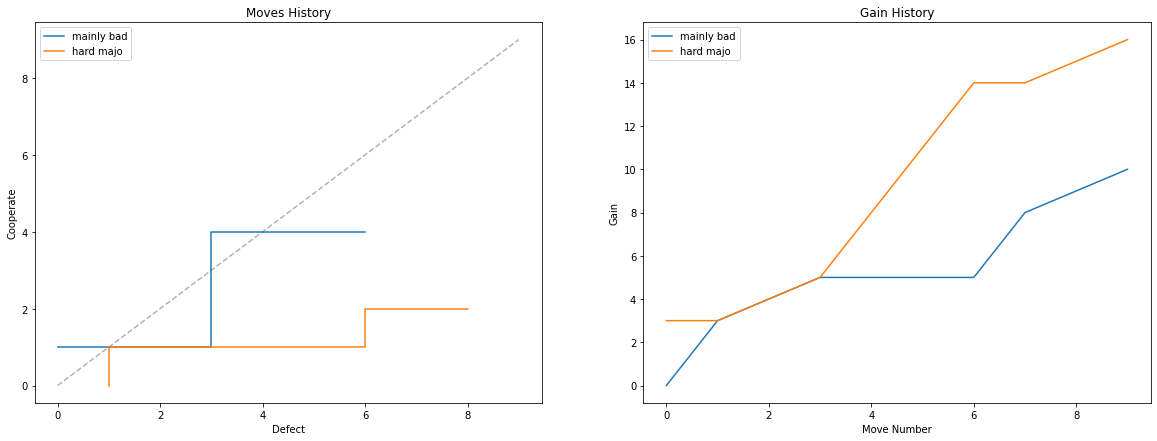

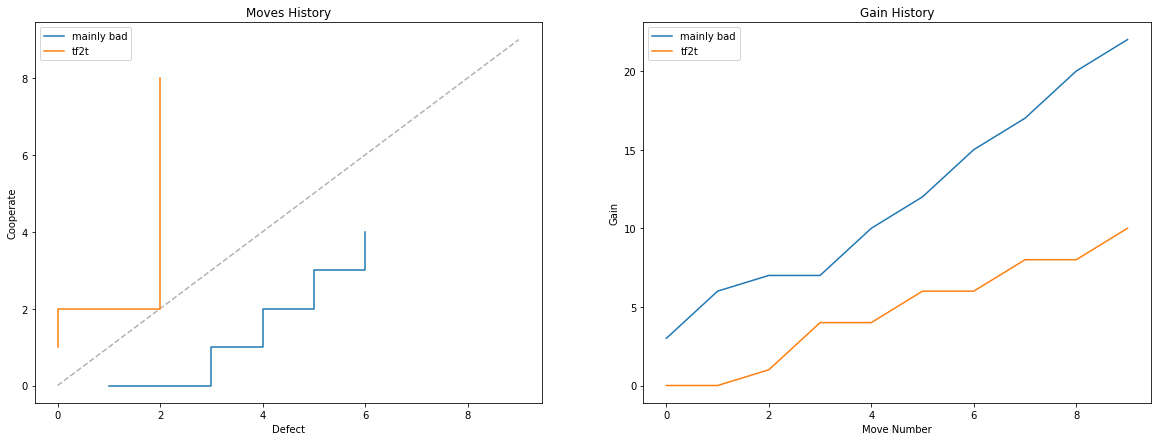

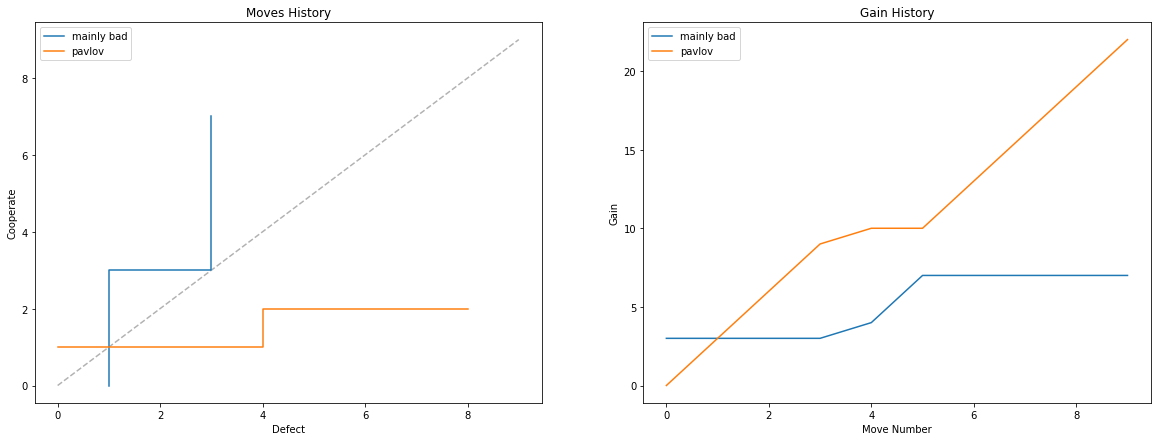

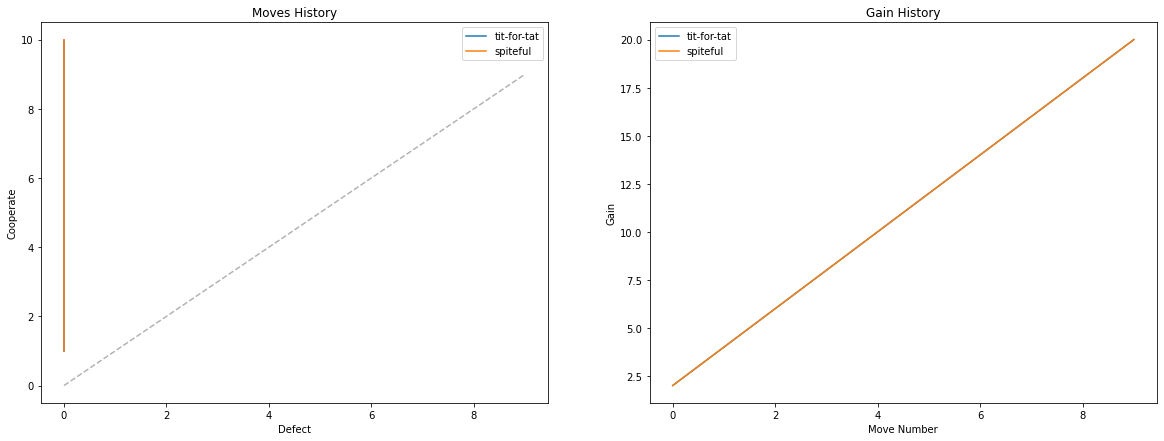

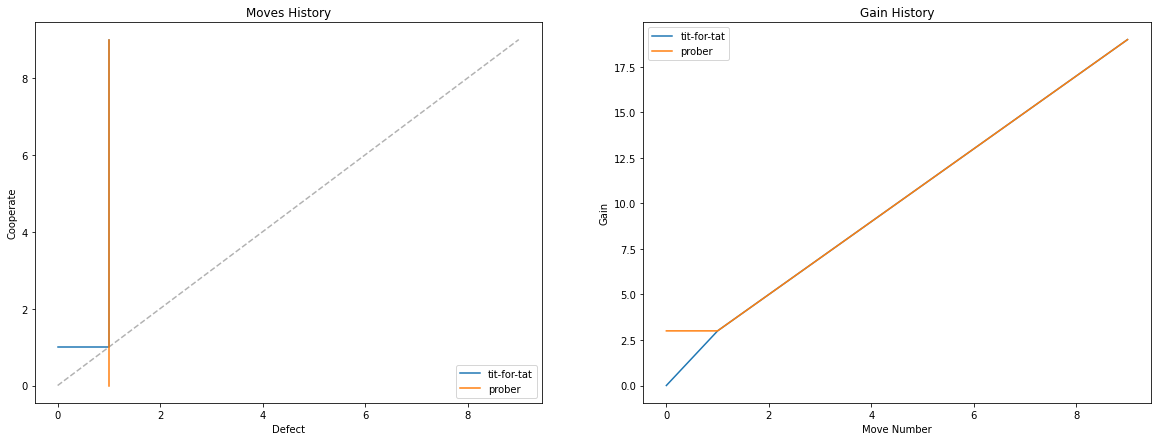

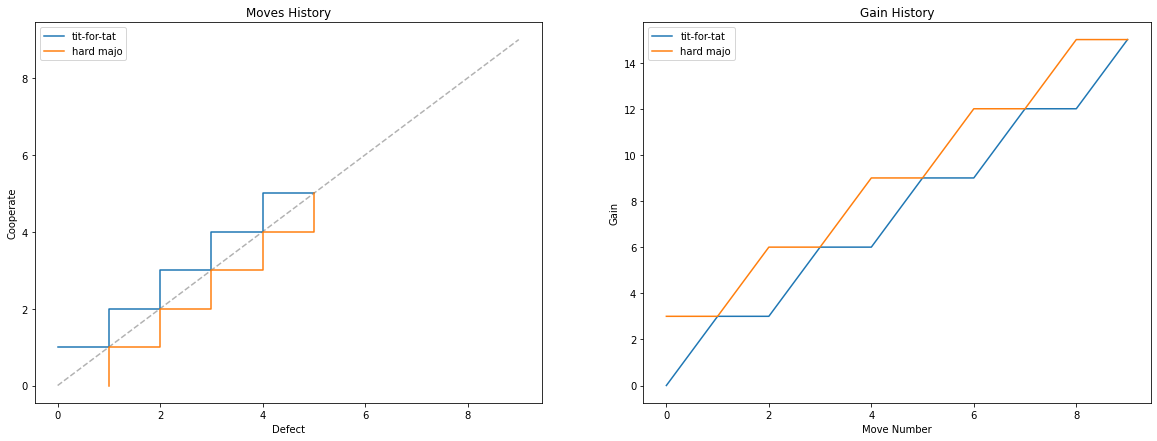

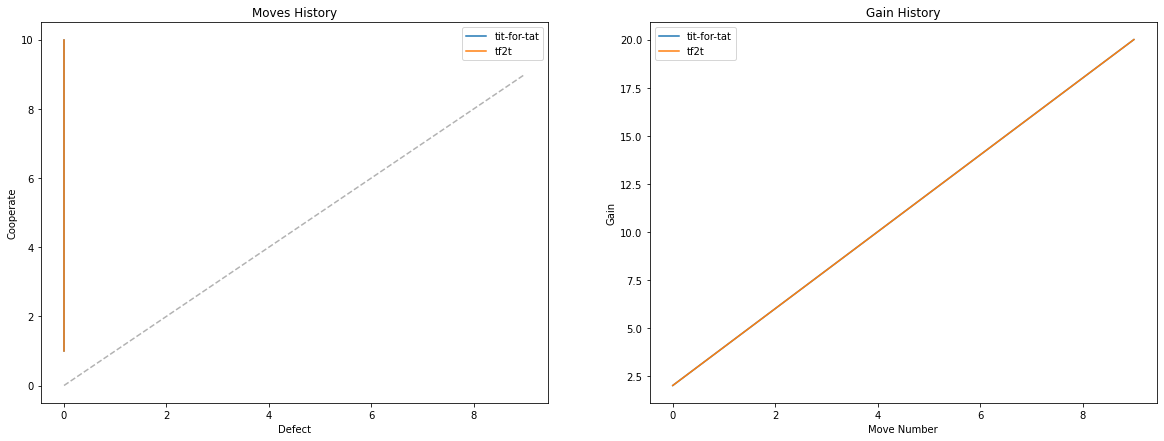

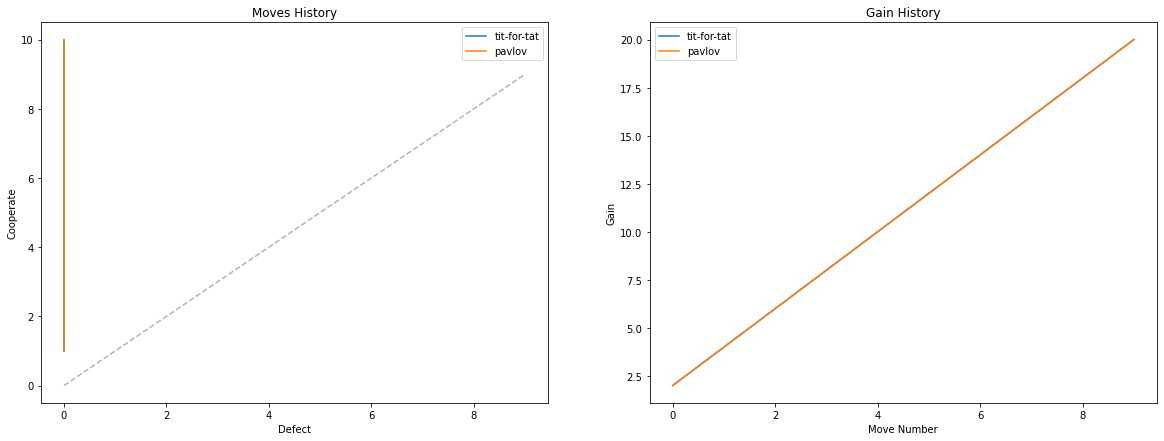

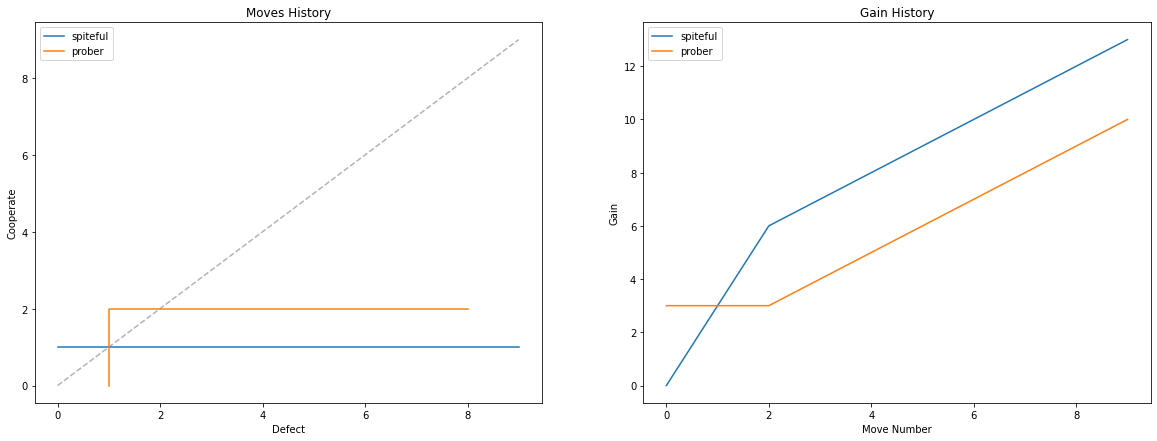

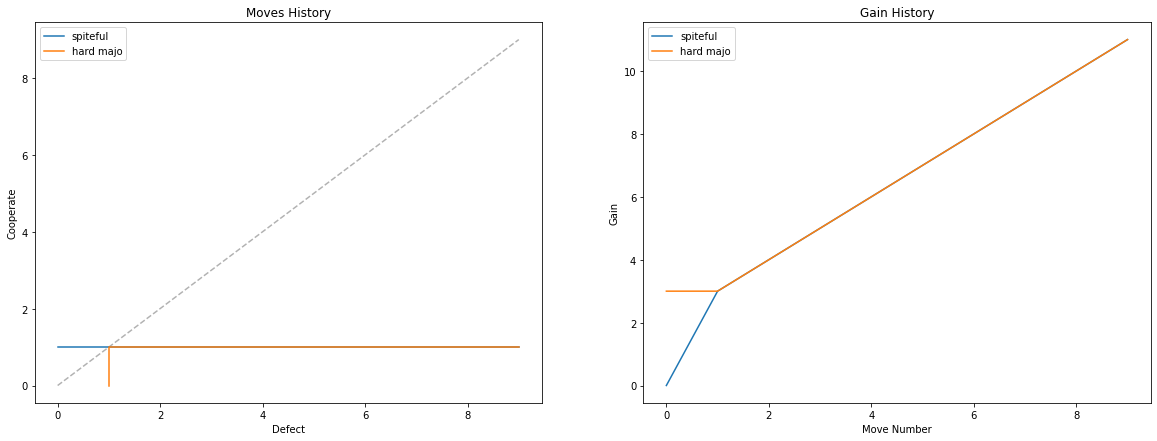

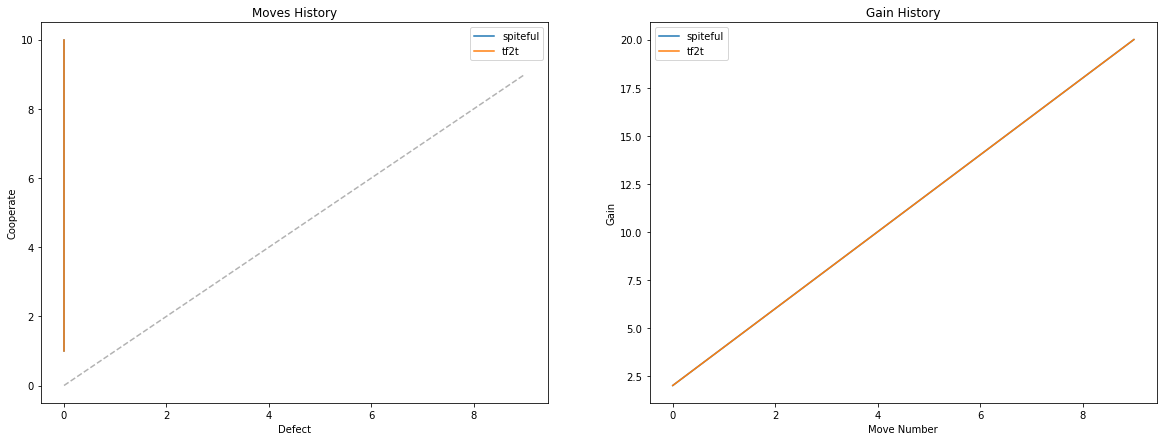

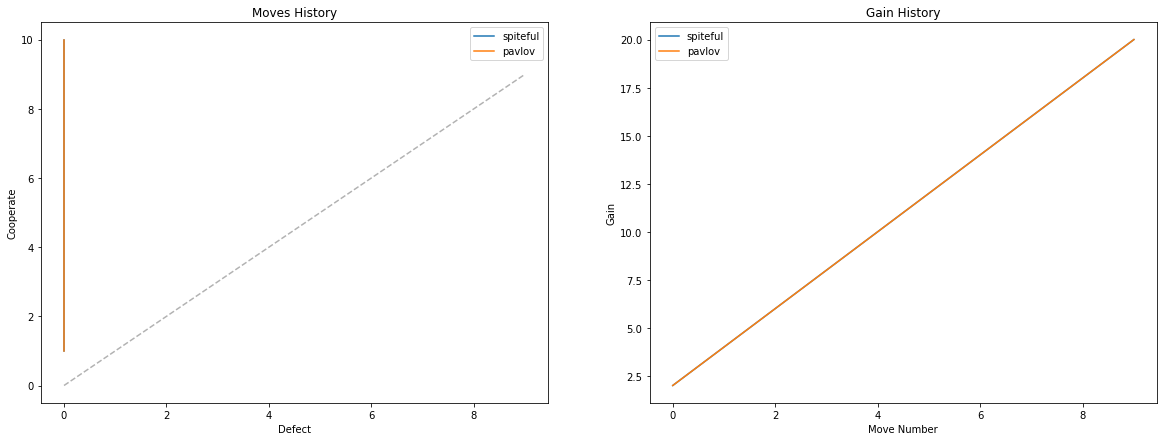

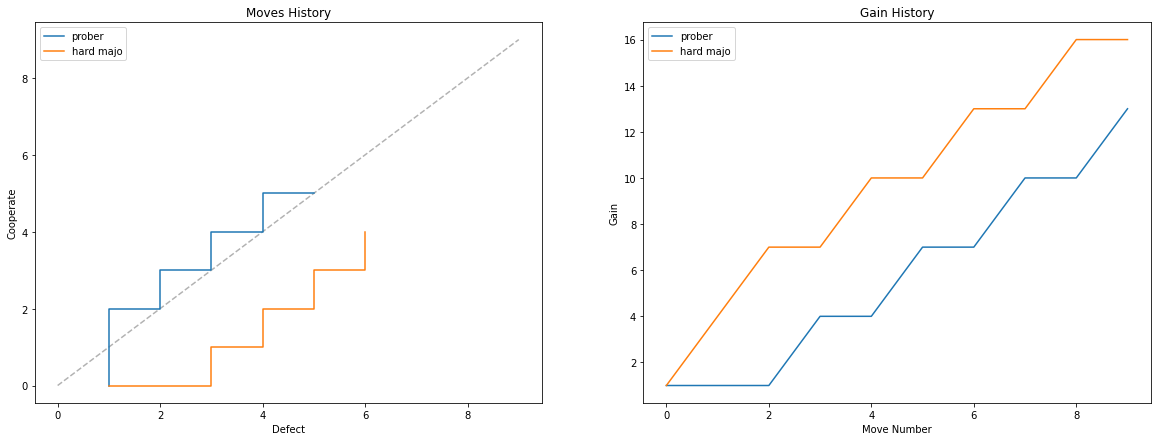

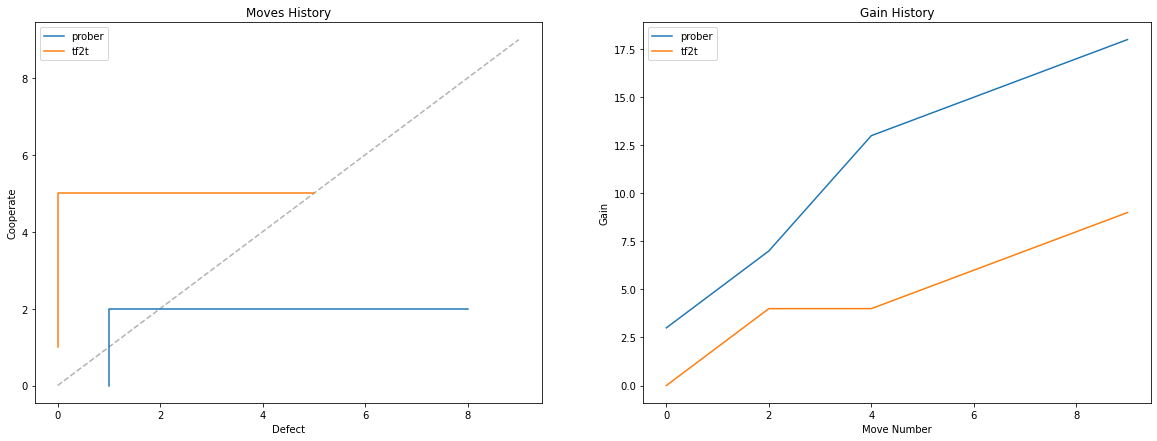

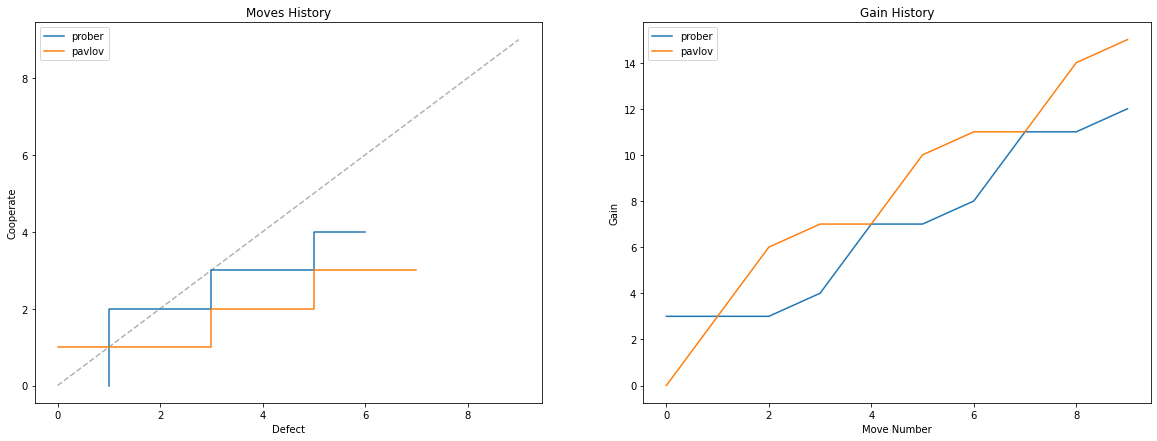

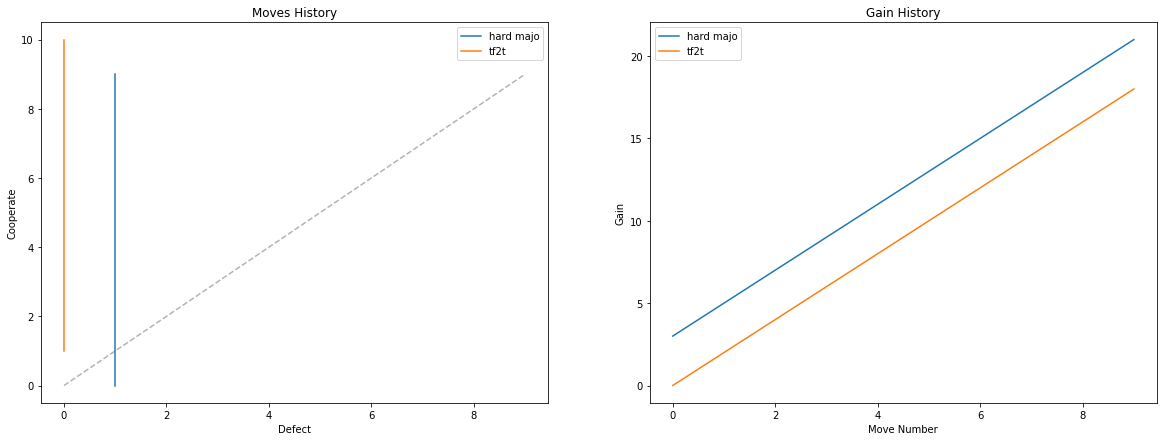

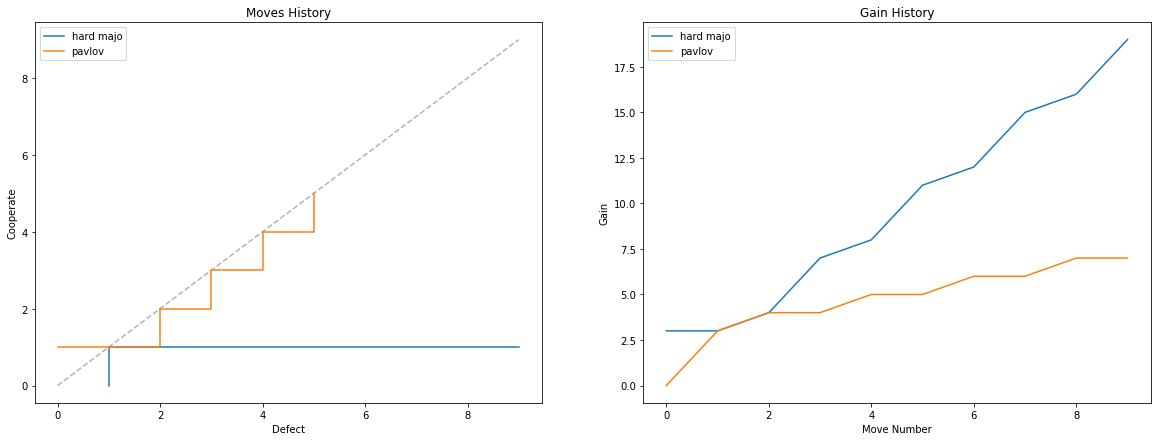

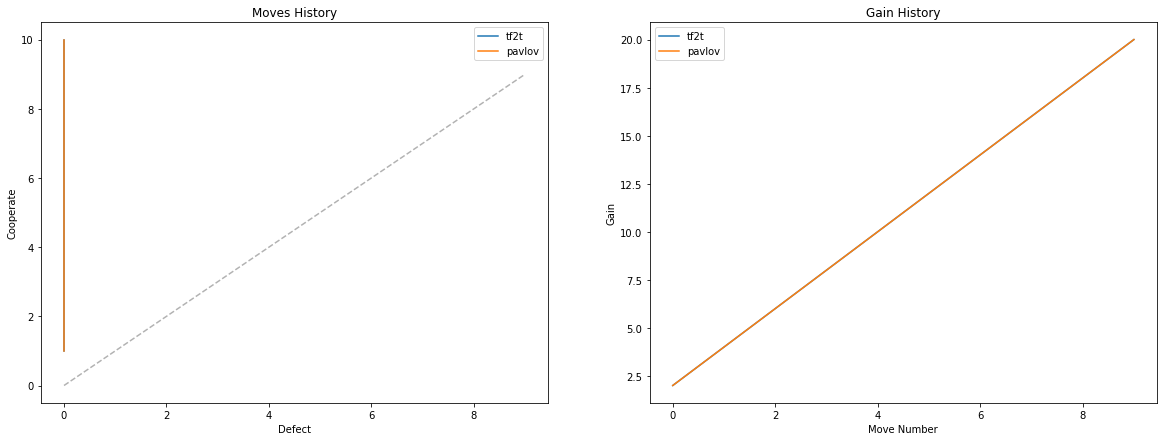

In [19]:
# Definition of the payoff matrix M
# (we assume it as a constant matrix)
R = 2; S = 0; T = 3; P = 1
M = np.array([[R, S], [T, P]])

# Number of rounds for each war
n = 10

# Generate players
players = generate_players(['nice', 'bad', 'mainly nice', 'mainly bad', \
  'tit-for-tat', 'spiteful', 'prober', 'hard majo', 'tf2t', 'pavlov'], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Combine the players in groups of 2 
war_combinations = combinations(players, 2)

# Simulate IPD
for item in war_combinations:
  war(item[0], item[1], n, M)

# Second Assignment

Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme.

Each _round\_robin\_tournament_ arranges the players following a round-robin scheme ("girone all'italiana") and then performs the battles.

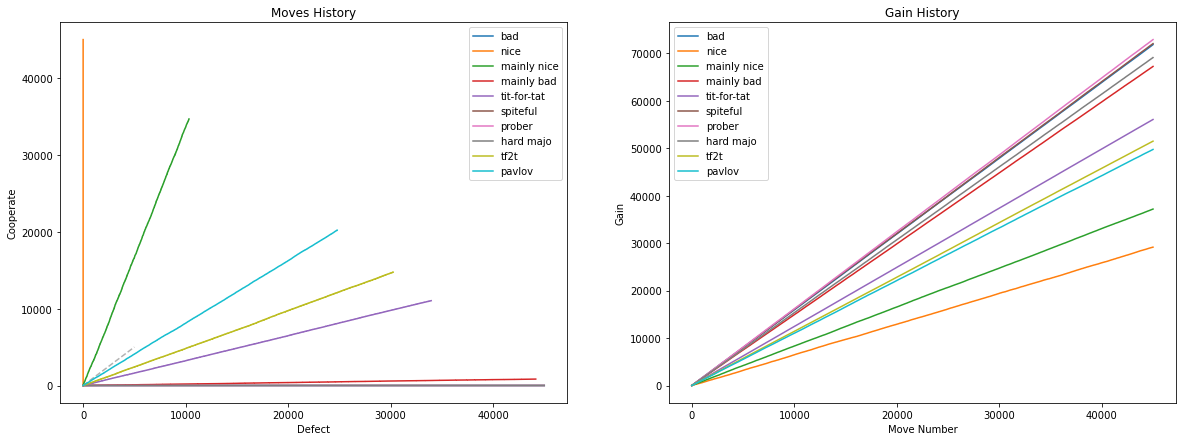

In [20]:
# Definition of the payoff matrix M
# (we assume it as a constant matrix)
R = 2; S = 0; T = 3; P = 1
M = np.array([[R, S], [T, P]])

# Number of tournaments
n = 1000
# Number of battles for each war
nb = 5

# Generate players
strategies = ['bad', 'nice', 'mainly nice', 'mainly bad', 'tit-for-tat', \
  'spiteful', 'prober', 'hard majo', 'tf2t', 'pavlov']
players = generate_players(strategies, np.full(len(strategies), 1))
# Simulate MPIPD
for i in range(0, n):
  round_robin_tournament(players, nb, M)

show_result(players, n)

# Third Assignment

Iterate what done in the previous task (repeated MPIPD, rMPIPD) by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration.

At the end of a round, the player with the lowest gain is removed and we add a player with the same strategy of who has the greatest gain.

Round 1 / 30 : + hard majo - mainly nice
Round 2 / 30 : + spiteful - nice
Round 3 / 30 : + spiteful - nice
Round 4 / 30 : + spiteful - nice
Round 5 / 30 : + hard majo - nice
Round 6 / 30 : + hard majo - nice
Round 7 / 30 : + spiteful - nice
Round 8 / 30 : + spiteful - nice
Round 9 / 30 : + spiteful - nice
Round 10 / 30 : + spiteful - nice
Round 11 / 30 : + spiteful - nice
Round 12 / 30 : + hard majo - mainly nice
Round 13 / 30 : + hard majo - mainly nice
Round 14 / 30 : + hard majo - mainly nice
Round 15 / 30 : + spiteful - mainly nice
Round 16 / 30 : + spiteful - mainly nice
Round 17 / 30 : + hard majo - mainly nice
Round 18 / 30 : + hard majo - mainly nice
Round 19 / 30 : + spiteful - mainly nice
Round 20 / 30 : + spiteful - mainly bad
Round 21 / 30 : + spiteful - pavlov
Round 22 / 30 : + spiteful - mainly nice
Round 23 / 30 : + spiteful - pavlov
Round 24 / 30 : + spiteful - pavlov
Round 25 / 30 : + spiteful - pavlov
Round 26 / 30 : + spiteful - pavlov
Round 27 / 30 : + spiteful - pa

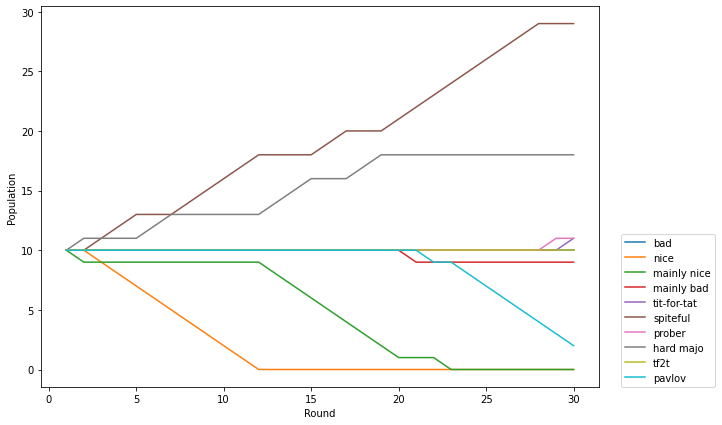

Final populations:
...bad 10.0
...nice 0.0
...mainly bad 9.0
... mainly nice 0.0
...tit-for-tat 11.0
...spiteful 29.0
...prober 11.0
...hard majo 18.0
...tf2t 10.0
...pavlov 2.0


In [21]:
# Definition of the payoff matrix M
# (we assume it as a constant matrix)
R = 2; S = 0; T = 3; P = 1
M = np.array([[R, S], [T, P]])

# Using an even number of players, everyone
# will perform the same number of moves. If
# instead this number is odd, the number of
# moves will not be the same for every player

strategies = ['bad', 'nice', 'mainly nice', 'mainly bad', 'tit-for-tat', \
  'spiteful', 'prober', 'hard majo', 'tf2t', 'pavlov']
np.random.shuffle(strategies)

# Generate players
n_players_per_strategy = 10
players = generate_players(strategies, \
  np.full(len(strategies), n_players_per_strategy))

# Simulate rMPIPD
n_tournaments = 5
n_rounds = 30
# Number of battles for each war
nb = 5

rounds = []

for j in range(0, n_rounds):

  # MPIPD (the same as assignment 2)
  for i in range(0, n_tournaments):
    round_robin_tournament(players, nb, M)

  p = [i.strategy for i in players]
  unique, counts = np.unique(p, return_counts = True)

  for s in strategies:
    if s not in unique:
      unique = np.append(unique, s)
      counts = np.append(counts, 0)

  rounds.append(dict(zip(unique, counts)))

  # At the end of each round we add 1 new player with
  # the same strategy of the player with maximum gain
  # in the current round

  # Show results of the current round
  #show_result(players, n_tournaments)

  # Find the player with maximum and minimun gain
  maxgain_P = max_gainP(players)
  mingain_P = min_gainP(players)
  new_P1 = Player(maxgain_P.strategy, maxgain_P.k)
  # Remove the player with minimun gain and add a new player with the 
  # the same strategy of the maximum gain player
  players.remove(mingain_P)
  players.append(new_P1)

  # Print the status of the round
  print('Round', j + 1, '/', n_rounds, ': +', new_P1.strategy, '-', mingain_P.strategy)

  # Reset attributes of all players
  reset(players)

show_populations(rounds)

# Fourth Assignment

Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natural selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.

As for assignment 3, at the end of each round we remove the player with the lowest gain and we add a player with the same strategy of the player with the greatest gain. But this time, in addition, every player can mutate its strategy based on the following probability:

$$
  \text{P[player i mutates strategy]} = p_{i} = 1 - \frac{totgain_{p}}{totgain_{max}}
$$

where $totgain_{p}$ is the total gain of the player and $totgain_{max}$ is the maximum gain. Then, we normalize these probabilities s.t. the expected value of
mutations per round is one, by multiplying $p_{i}$ for the factor $c$:

$$
  \sum_{i \in players} c \cdot p_{i} = 1 \Rightarrow c = \frac{1}{\sum_{i \in players} p_{i}}
$$

Therefore the final probability of mutation for the player $i$ is:
$$
  \text{P[player i mutates strategy]} = \frac{p_{i}}{\sum_{i \in players} p_{i}}
$$


Round 1 / 100 : + prober - hard majo
                a bad player mutated to tit-for-tat
Round 2 / 100 : + prober - nice
Round 3 / 100 : + prober - nice
                a pavlov player mutated to hard majo
Round 4 / 100 : + prober - mainly nice
                a hard majo player mutated to mainly nice
                a tf2t player mutated to spiteful
Round 5 / 100 : + prober - nice
Round 6 / 100 : + prober - nice
                a mainly nice player mutated to spiteful
Round 7 / 100 : + prober - mainly nice
                a tit-for-tat player mutated to tf2t
                a prober player mutated to mainly bad
                a prober player mutated to spiteful
Round 8 / 100 : + spiteful - pavlov
                a mainly nice player mutated to mainly nice
                a tit-for-tat player mutated to bad
Round 9 / 100 : + bad - pavlov
                a tf2t player mutated to bad
Round 10 / 100 : + tit-for-tat - mainly nice
                a prober player mutated to mainly nice
Roun

Round 92 / 100 : + tit-for-tat - spiteful
                a spiteful player mutated to pavlov
                a mainly nice player mutated to tf2t
                a tf2t player mutated to prober
Round 93 / 100 : + prober - prober
                a tit-for-tat player mutated to mainly bad
                a tit-for-tat player mutated to mainly nice
Round 94 / 100 : + tf2t - prober
                a mainly nice player mutated to pavlov
Round 95 / 100 : + tit-for-tat - spiteful
Round 96 / 100 : + tf2t - tit-for-tat
                a tit-for-tat player mutated to mainly bad
Round 97 / 100 : + tf2t - spiteful
                a mainly bad player mutated to mainly bad
                a tit-for-tat player mutated to spiteful
Round 98 / 100 : + tf2t - mainly bad
Round 99 / 100 : + tf2t - tit-for-tat
                a tf2t player mutated to tit-for-tat
Round 100 / 100 : + tit-for-tat - tit-for-tat


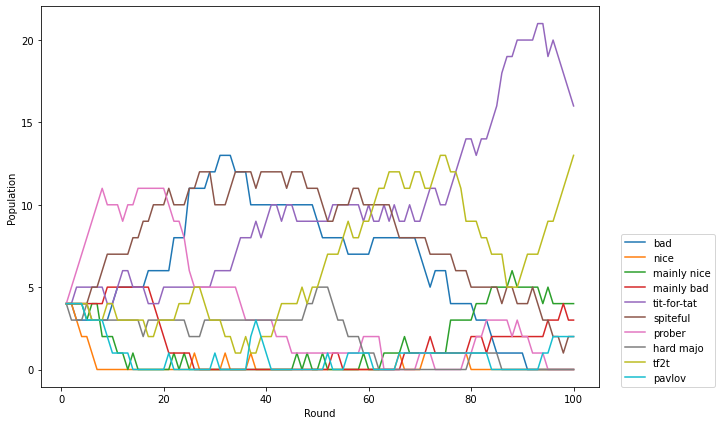

Final populations:
...bad 0.0
...nice 0.0
...mainly bad 3.0
... mainly nice 4.0
...tit-for-tat 16.0
...spiteful 2.0
...prober 0.0
...hard majo 0.0
...tf2t 13.0
...pavlov 2.0


In [22]:
# Definition of the payoff matrix M
# (we assume it as a constant matrix)
R = 2; S = 0; T = 3; P = 1
M = np.array([[R, S], [T, P]])

# Using an even number of players, everyone
# will perform the same number of moves. If
# instead this number is odd, the number of
# moves will not be the same for every player

strategies = ['bad', 'nice', 'mainly nice', 'mainly bad', 'tit-for-tat', \
  'spiteful', 'prober', 'hard majo', 'tf2t', 'pavlov']
np.random.shuffle(strategies)

# Generate players
n_players_per_strategy = 4
players = generate_players(strategies, \
  np.full(len(strategies), n_players_per_strategy))

# Simulate rMPIPD
n_tournaments = 2
n_rounds = 100
# Number of battles for each war
nb = 10

rounds = []

for j in range(0, n_rounds):
  # MPIPD (the same as assignment 2)
  for i in range(0, n_tournaments):
    round_robin_tournament(players, nb, M)

  p = [i.strategy for i in players]
  unique, counts = np.unique(p, return_counts = True)

  for s in strategies:
    if s not in unique:
      unique = np.append(unique, s)
      counts = np.append(counts, 0)

  rounds.append(dict(zip(unique, counts)))

  # At the end of each round we add 1 new player with
  # the same strategy of the player with maximum gain
  # in the current round

  # Show results of the current round
  #show_result(players, n_tournaments)

  # Find the player with maximum and minimun gain
  maxgain_P = max_gainP(players)
  mingain_P = min_gainP(players)
  new_P1 = Player(maxgain_P.strategy, maxgain_P.k)
  # Remove the player with minimun gain and add a new player with the 
  # the same strategy of the maximum gain player
  players.remove(mingain_P)
  players.append(new_P1)
    
  # Strategy mutation

  # No mutation in the first round: we don't have any info
  # on the gain
  if j != 0:     
    # Compute the probability of mutation as 1 - (the total gain of the player over the
    # maximum total gain)
    prob = [1 - np.sum(a.gain)/np.sum(maxgain_P.gain) for a in players]
    # Then normalize the sum of all the probabilities to 1, such that the expected value of
    # mutation per round is one
    c = 1/np.sum(prob)
    prob = [a*c for a in prob]
    for i in range(len(players)):
      choice = np.random.choice([1, 0], p = [prob[i], 1 - prob[i]])
      if choice == 1:
        tmp = players[i].strategy
        s = random.choice(strategies)
        if(s == 'mainly nice'):
          w = random.random()
          while(w >= 0.5):
            w = random.random() 
          players[i].k = w
        elif(s == 'mainly bad'):
          w = random.random()
          while(w < 0.5):
            w = random.random() 
          players[i].k = w

        players[i].strategy = s
        print('                a', tmp, 'player mutated to', s)
    
  # Print the status of the round
  print('Round', j + 1, '/', n_rounds, ': +', new_P1.strategy, '-', mingain_P.strategy)
  # print('               a', tmp, 'player mutated to', mad_P.strategy)

  # Reset attributes of all players
  reset(players)

show_populations(rounds)

# Conclusions

According to the experiments run through all the four assignments we can state that:

*   In the first two assignment the best strategy is always the one adopted by the "bad" player, i.e. always defect. This is quite trivial because using that strategy the player wins a reward in every case, so it's more probable for him to have the higher gain.
*   On the other hand, in the third and even more in the fourth assignments, the "bad" strategy is no more the winner every time, because the mutation and the variation of the population factors are added to the game. This causes that the players who change their strategy based on the moves of the opponent often reach the higher population at the end of the tournament. In particular the best strategies are "spiteful", "tf2t" and "tit-for-tat".
*   We tested different values of the Payoff Matrix M, observing that it doesn't affect the results in a relevant way.